# Topography Correction



Here, we show how to use 'harmonica' https://www.fatiando.org/harmonica/latest/ to remove topography effect

See https://www.fatiando.org/harmonica/latest/user_guide/topographic_correction.html for more information

In [1]:
# Load necessary package 
import harmonica as hm
import pandas as pd
import pyproj
import matplotlib.pyplot as plt
import numpy as np
import verde as vd

C:\Users\li353\Anaconda3\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\li353\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\li353\Anaconda3\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


# Read in Free Air Gravity Disturbance after normal earth correction

In [2]:
#Read in Gravity data after drift correction
Data = pd.read_csv('Free_Air_Grav_CAGE_FIELD.csv', delimiter=r',')

In [3]:
# Let's look few line of the data
Data.head()

,STATION,LINE,Lon,Lat,Height_Ellipsoid,Height_Sealevel,Total Gravity,Free Air Disturbance
0,2.0,200.0,116.221272,-31.521204,206.730,235.60,1.494362,-2.183071
1,2.0,300.0,116.221281,-31.520428,209.068,237.94,1.547080,-1.346266
2,4.0,200.0,116.220166,-31.521275,217.752,246.63,0.230452,-0.050988
3,4.0,300.0,116.220229,-31.520332,216.532,245.41,1.126149,0.544137
4,6.0,200.0,116.219096,-31.521241,221.841,250.72,-0.506791,0.476491


# Topography correction

We need to remove the 3D topography mass from the Free Air disturbance. Here we use DEM from global topography grid to do that. You could use high resolution topography grid in your own study area.

Important: Remember to match the topography resolution with gravity

In [4]:
# Load topography grid
import xarray as xr
topography = xr.load_dataarray('dem_50m_wgs84.tif')


In [5]:
topography

<xarray.DataArray 'band_data' (band: 1, y: 1475, x: 1438)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 115.9 115.9 115.9 115.9 ... 116.6 116.6 116.6 116.6
  * y            (y) float64 -31.18 -31.18 -31.18 ... -31.88 -31.88 -31.88
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area

In [6]:
# Let's crop it to the gravity region (slightly larger):
region = vd.get_region((Data.Lon, Data.Lat))
region_pad = vd.pad_region(region, pad=0.1)

topography = topography[0].sel(
    x=slice(region_pad[0], region_pad[1]),
    y=slice(region_pad[3], region_pad[2]),
)
topography

<xarray.DataArray 'band_data' (y: 426, x: 450)>
array([[168.90941 , 164.15047 , 160.7174  , ..., 321.90744 , 321.90744 ,
        318.43134 ],
       [158.03287 , 165.55136 , 164.93854 , ..., 317.5285  , 314.8234  ,
        314.70477 ],
       [151.4196  , 151.4196  , 158.00603 , ..., 315.8833  , 311.857   ,
        313.31418 ],
       ...,
       [ 96.90427 ,  81.463806,  77.41324 , ..., 268.55264 , 266.55283 ,
        261.6953  ],
       [103.667435,  92.48909 ,  85.32896 , ..., 270.13345 , 274.7156  ,
        274.7156  ],
       [108.7789  ,  92.27544 ,  87.54803 , ..., 270.15244 , 275.99005 ,
        282.4644  ]], dtype=float32)
Coordinates:
    band         int32 1
  * x            (x) float64 116.1 116.1 116.1 116.1 ... 116.3 116.3 116.3 116.3
  * y            (y) float64 -31.42 -31.42 -31.42 ... -31.62 -31.62 -31.62
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area

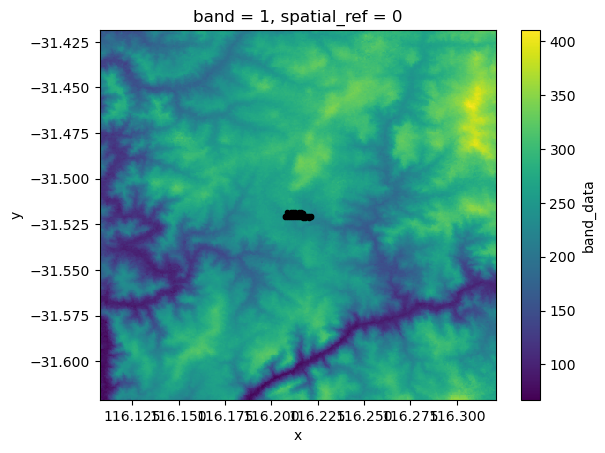

In [7]:
topography.plot()
plt.plot(Data['Lon'], Data['Lat'],'k.')

# Projection

Right now everything is in Geographic coordinate system (longtidude and latitude), in small scales, projection system in meters will be easier to handle. So here, we use EPSG:28350

In [8]:
# Define the projection
projection = pyproj.Proj('EPSG:28350')

# Project the topography grid use verde
topography_proj = vd.project_grid(topography.dropna(dim='x').dropna(dim='y'), projection, method="nearest")
topography_proj

# We also need to project the gravity location:
# Project the coordinates of the observation points
easting, northing = projection(Data.Lon.values, Data.Lat.values)

# Note we need to use Height_Sealevel to match the DEM
coordinates = (easting, northing, Data['Height_Sealevel'])

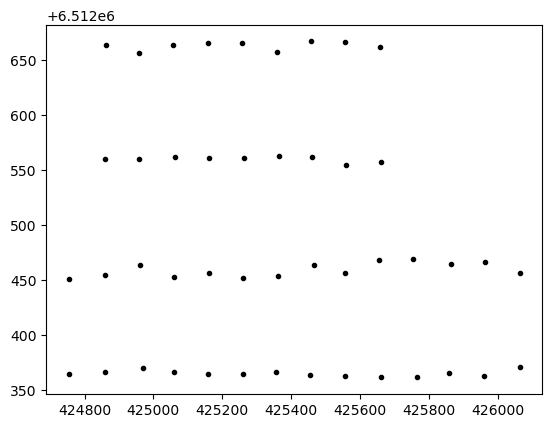

In [9]:
#topography_proj.plot()
plt.plot(easting, northing,'k.')

# Calculate topography graivty effect

We want to compute topography graivty effect use harmonica.DatasetAccessorPrismLayer.gravity, it generate a series of prism to represent the topography, and then do forward gravity calculation. In order to do that, we also need to define the density distribution first.

For every prism above the ellipsoid we will set the density of the upper crust (2670 kg/m3), while for each prism below it we will assign the density contrast equal to the density of the water (1040 kg/m3) minus the density of the upper crust.

You could change the density value to fit your local geology

In [10]:
density = np.where(topography_proj >= 0, 2670, 1040 - 2670)

prisms = hm.prism_layer(
    (topography_proj.easting, topography_proj.northing),
    surface=topography_proj,
    reference=0,
    properties={"density": density},
)
prisms

<xarray.Dataset>
Dimensions:   (northing: 426, easting: 450)
Coordinates:
  * easting   (easting) float64 4.152e+05 4.152e+05 ... 4.356e+05 4.356e+05
  * northing  (northing) float64 6.501e+06 6.501e+06 ... 6.524e+06 6.524e+06
    top       (northing, easting) float32 nan nan nan nan ... nan nan nan nan
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    density   (northing, easting) int32 -1630 -1630 -1630 ... -1630 -1630 -1630
Attributes:
    coords_units:      meters
    properties_units:  SI

In [11]:
# Compute the terrain effect
terrain_effect = prisms.prism_layer.gravity(coordinates, field="g_z")

We do Similar things to far field topography

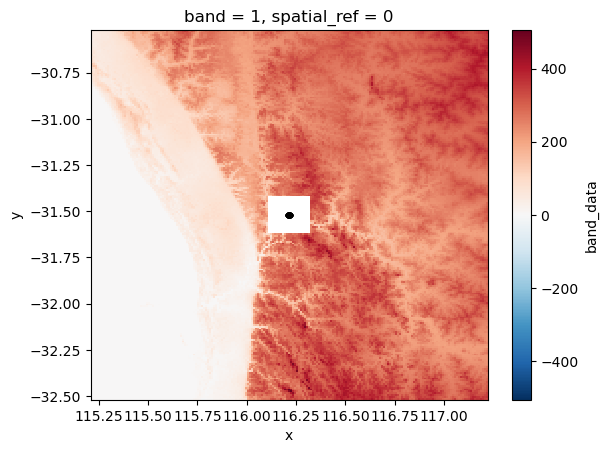

In [12]:
# Load the data array
topography_far = xr.load_dataarray('dem.tif')

# Get the region based on gravity data (Lon, Lat from the Data variable)
region = vd.get_region((Data.Lon, Data.Lat))

# Pad the region slightly for cropping purposes (1 degree padding, for example)
region_pad_large = vd.pad_region(region, pad=1)

# Select the middle box (region_pad_large) by slicing and set the values to NaN
topography = topography_far.copy()

topography = topography[0].sel(
    x=slice(region_pad_large[0], region_pad_large[1]),
    y=slice(region_pad_large[3], region_pad_large[2]),
)


topography_far_middle_nan = topography.copy()


topography_far_middle_nan.loc[dict(
    x=slice(region_pad[0], region_pad[1]), 
    y=slice(region_pad[3], region_pad[2])
)] = np.nan

# Plot the modified topography
topography_far_middle_nan.plot()
plt.plot(Data['Lon'], Data['Lat'], 'k.')
plt.show()


In [13]:
topography_far_middle_nan

<xarray.DataArray 'band_data' (y: 200, x: 201)>
array([[ 45.,  48.,  43., ..., 357., 365., 388.],
       [ 39.,  40.,  41., ..., 362., 364., 380.],
       [ 41.,  41.,  42., ..., 344., 356., 360.],
       ...,
       [  0.,   0.,   0., ..., 323., 337., 347.],
       [  0.,   0.,   0., ..., 356., 350., 356.],
       [  0.,   0.,   0., ..., 358., 340., 332.]], dtype=float32)
Coordinates:
    band         int32 1
  * x            (x) float64 115.2 115.2 115.2 115.2 ... 117.2 117.2 117.2 117.2
  * y            (y) float64 -30.52 -30.54 -30.54 -30.55 ... -32.49 -32.5 -32.52
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        1963.9197998047
    STATISTICS_MEAN:           235.98416798901
    STATISTICS_MINIMUM:        -28.85756111145
    STATISTICS_STDDEV:         202.53354550359
    STATISTICS_VALID_PERCENT:  48.85

In [14]:
topography_proj = vd.project_grid(topography_far_middle_nan, projection, method="nearest")
topography_proj


density = np.where(topography_proj >= 0, 2670, 1040 - 2670)

prisms = hm.prism_layer(
    (topography_proj.easting, topography_proj.northing),
    surface=topography_proj,
    reference=0,
    properties={"density": density},
)
prisms

<xarray.Dataset>
Dimensions:   (northing: 200, easting: 201)
Coordinates:
  * easting   (easting) float64 3.287e+05 3.297e+05 ... 5.197e+05 5.206e+05
  * northing  (northing) float64 6.401e+06 6.402e+06 ... 6.622e+06 6.623e+06
    top       (northing, easting) float32 nan nan nan nan ... nan nan nan nan
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables:
    density   (northing, easting) int32 -1630 -1630 -1630 ... -1630 -1630 -1630
Attributes:
    coords_units:      meters
    properties_units:  SI

In [15]:
# Compute the terrain effect
terrain_effect_far = prisms.prism_layer.gravity(coordinates, field="g_z")

In [16]:
# The topography-free gravity disturbance:
topo_free_disturbance = Data['Free Air Disturbance'] - terrain_effect - terrain_effect_far

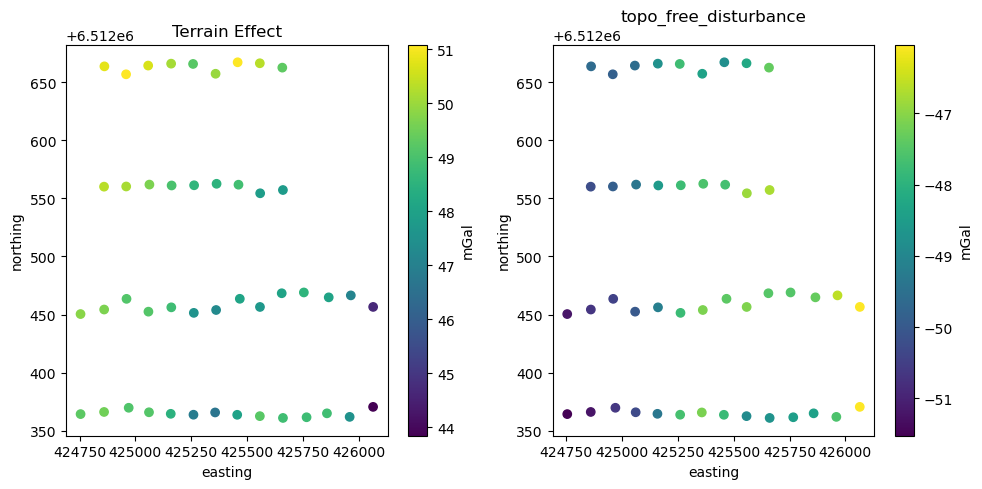

In [17]:
# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First subplot: Drift over time
sc = axs[0].scatter(easting, northing, c=terrain_effect+terrain_effect_far, cmap='viridis')
axs[0].set_xlabel('easting')
axs[0].set_ylabel('northing')
axs[0].set_title("Terrain Effect")
plt.colorbar(sc, ax=axs[0], label='mGal')

# Second subplot: Drift for each locations
sc = axs[1].scatter(easting, northing, c=topo_free_disturbance, cmap='viridis')
axs[1].set_xlabel('easting')
axs[1].set_ylabel('northing')
axs[1].set_title("topo_free_disturbance")
plt.colorbar(sc, ax=axs[1], label='mGal')

# Display the plot
plt.tight_layout()
plt.show()

In [18]:
# Save the Data to a CSV file
data_array = np.column_stack((Data['Lon'], Data['Lat'], easting, northing, Data['Height_Ellipsoid'], Data['Height_Sealevel'], Data['Total Gravity'], Data['Free Air Disturbance'],topo_free_disturbance))
df = pd.DataFrame(data_array, columns=['Lon', 'Lat', 'Easting', 'Northing', 'Height_Ellipsoid', 'Height_Sealevel', 'Total Gravity', 'Free Air Disturbance','Topo Free Disturbance'])
df.to_csv('Topo_Free_Grav_CAGE_FIELD.csv', index=False)

In the next notebook, we will use the gravity data to run inversion !!!!!!!!!!!!!!!!!!!